In [1]:
# import libraries
import os
import re
import pathlib
from glob import glob

import matplotlib.pyplot as plt
import earthaccess
import xrspatial
import geopandas as gpd
import rioxarray as rxr
import rioxarray.merge as rxrmerge

c:\Users\moenc\miniconda3\envs\earth-analytics-python\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
%store -r curl_gdf b_soil_url_list

In [3]:
# build project and elevation directories

data_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data'
)
project_dir = os.path.join(data_dir, 'habitat_suitability3')
elevation_dir = os.path.join(data_dir, 'srtm3')

os.makedirs(elevation_dir, exist_ok=True)
data_dir

'C:\\Users\\moenc\\earth-analytics\\data'

In [4]:
# login to earthaccess
earthaccess.login(strategy="interactive", persist=True)

In [5]:
# search for the appropriate DEM

datasets = earthaccess.search_datasets(keyword='SRTM DEM', count=11)
for dataset in datasets:
    print(dataset['umm']['ShortName'], dataset['umm']['EntryTitle'])

NASADEM_SHHP NASADEM SRTM-only Height and Height Precision Mosaic Global 1 arc second V001
NASADEM_SIM NASADEM SRTM Image Mosaic Global 1 arc second V001
NASADEM_SSP NASADEM SRTM Subswath Global 1 arc second V001
C_Pools_Fluxes_CONUS_1837 CMS: Terrestrial Carbon Stocks, Emissions, and Fluxes for Conterminous US, 2001-2016
SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
GEDI01_B GEDI L1B Geolocated Waveform Data Global Footprint Level V002
GEDI02_B GEDI L2B Canopy Cover and Vertical Profile Metrics Data Global Footprint Level V002
NASADEM_HGT NASADEM Merged DEM Global 1 arc second V001
SRTMGL3 NASA Shuttle Radar Topography Mission Global 3 arc second V003
SRTMGL1_NC NASA Shuttle Radar Topography Mission Global 1 arc second NetCDF V003
SRTMGL30 NASA Shuttle Radar Topography Mission Global 30 arc second V002


In [6]:
curl_gdf.bounds

,minx,miny,maxx,maxy
16,-112.869628,42.029103,-112.522562,42.331612


In [7]:
print(os.listdir(elevation_dir))

[]


In [11]:
# Define a pattern to identify DEM tiles associated with Sheyenne National Grassland.
srtm_b_pattern = os.path.join(elevation_dir, 'N42*hgt.zip')
bounds_b = tuple(curl_gdf.total_bounds)
buffer = 0.25
xmin, ymin, xmax, ymax = bounds_b
bounds_buffer = (xmin-buffer, ymin-buffer, xmax+buffer, ymax+buffer)
if not glob(srtm_b_pattern):
    srtm_b_results = earthaccess.search_data(
        short_name = "SRTMGL1",
        bounding_box=bounds_buffer    
    )
    srtm_b_results = earthaccess.download(srtm_b_results, elevation_dir)

QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

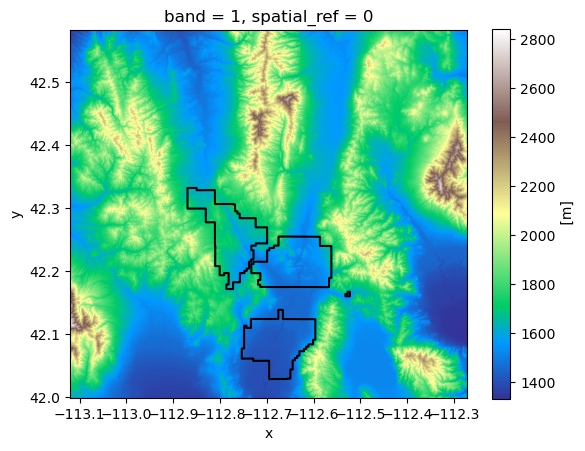

In [12]:
# Print the DEM for Comanche natl. Grassland
srtm_b_da_list=[]
for srtm_b_path in glob(srtm_b_pattern):
    tile_da = rxr.open_rasterio(srtm_b_path, mask_and_scale=True).squeeze()
    cropped_da = tile_da.rio.clip_box(*bounds_buffer)
    srtm_b_da_list.append(cropped_da)
    
srtm_a_da = rxrmerge.merge_arrays(srtm_b_da_list)
srtm_a_da.plot(cmap='terrain')
curl_gdf.boundary.plot(ax=plt.gca(), color='black')